# Tarea 3: Modelo Hard-Core y q-Coloraciones con Gibbs Sampler

**Integrantes:**
- Jos√© Miguel Acu√±a Hern√°ndez
- Andr√©s Puertas Londo√±o
- Guillermo Murillo Tirado

**Curso:** Cadenas de Markov 2025-II  
**Profesor:** Freddy Hern√°ndez

## 1. Importaciones y Configuraci√≥n del Entorno

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import pandas as pd
from typing import Tuple, List
import warnings

# Configuraci√≥n de visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Semilla para reproducibilidad
np.random.seed(42)

print("Entorno configurado correctamente")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

/home/andrespl/anaconda3/lib/python3.13/site-packages/numpy/_core/getlimits.py:548: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


Entorno configurado correctamente
NumPy version: 2.1.3
Matplotlib version: 3.10.0
Seaborn version: 0.13.2


## 2. Modelo Hard-Core - Implementaci√≥n del Gibbs Sampler

El modelo Hard-Core representa configuraciones de part√≠culas en una rejilla donde ninguna pareja de part√≠culas puede ser adyacente. Una configuraci√≥n es v√°lida si para cada par de v√©rtices adyacentes, al menos uno est√° vac√≠o.

In [2]:
def es_configuracion_factible_hardcore(config: np.ndarray) -> bool:
    """
    Verifica si una configuraci√≥n es factible para el modelo Hard-Core.
    Una configuraci√≥n es factible si no hay dos part√≠culas adyacentes.
    
    Args:
        config: Matriz K√óK con valores 0 (vac√≠o) o 1 (part√≠cula)
    
    Returns:
        True si la configuraci√≥n es factible, False en caso contrario
    """
    K = config.shape[0]
    
    for i in range(K):
        for j in range(K):
            if config[i, j] == 1:
                # Verificar vecinos (arriba, abajo, izquierda, derecha)
                vecinos = []
                if i > 0:
                    vecinos.append(config[i-1, j])
                if i < K-1:
                    vecinos.append(config[i+1, j])
                if j > 0:
                    vecinos.append(config[i, j-1])
                if j < K-1:
                    vecinos.append(config[i, j+1])
                
                # Si alg√∫n vecino tiene part√≠cula, no es factible
                if any(v == 1 for v in vecinos):
                    return False
    
    return True


def gibbs_sampler_hardcore(K: int, T: int, config_inicial: np.ndarray = None) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    Implementa el Gibbs Sampler para el modelo Hard-Core.
    
    Args:
        K: Tama√±o de la rejilla (K√óK)
        T: N√∫mero de iteraciones
        config_inicial: Configuraci√≥n inicial (si None, se genera aleatoriamente)
    
    Returns:
        config_final: Configuraci√≥n final despu√©s de T iteraciones
        historia: Lista con configuraciones guardadas en pasos espec√≠ficos
    """
    # Inicializar configuraci√≥n
    if config_inicial is None:
        config = np.zeros((K, K), dtype=int)
    else:
        config = config_inicial.copy()
    
    # Lista para guardar configuraciones en ciertos puntos
    historia = [config.copy()]  # t=0
    puntos_guardado = [100, 1000, 5000, T]  # Puntos donde guardar la configuraci√≥n
    
    for t in range(1, T + 1):
        # Actualizar cada v√©rtice secuencialmente
        for i in range(K):
            for j in range(K):
                # Verificar vecinos
                tiene_vecino_ocupado = False
                
                if i > 0 and config[i-1, j] == 1:
                    tiene_vecino_ocupado = True
                if i < K-1 and config[i+1, j] == 1:
                    tiene_vecino_ocupado = True
                if j > 0 and config[i, j-1] == 1:
                    tiene_vecino_ocupado = True
                if j < K-1 and config[i, j+1] == 1:
                    tiene_vecino_ocupado = True
                
                # Actualizar el v√©rtice seg√∫n la restricci√≥n
                if tiene_vecino_ocupado:
                    # Forzar a estar vac√≠o
                    config[i, j] = 0
                else:
                    # Elegir uniformemente 0 o 1
                    config[i, j] = np.random.choice([0, 1])
        
        # Guardar configuraci√≥n en puntos espec√≠ficos
        if t in puntos_guardado:
            historia.append(config.copy())
    
    return config, historia


def visualizar_configuracion_hardcore(config: np.ndarray, titulo: str = "Configuraci√≥n Hard-Core"):
    """
    Visualiza una configuraci√≥n del modelo Hard-Core.
    
    Args:
        config: Matriz K√óK con valores 0 (vac√≠o) o 1 (part√≠cula)
        titulo: T√≠tulo del gr√°fico
    """
    K = config.shape[0]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Usar colormap blanco para 0, negro para 1
    cmap = ListedColormap(['white', 'black'])
    
    ax.imshow(config, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
    
    # Agregar l√≠neas de cuadr√≠cula
    ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    num_particulas = np.sum(config)
    ax.set_title(f"{titulo}\nN√∫mero de part√≠culas: {num_particulas}", fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    return fig


# Test de funcionalidad
print("Funciones del modelo Hard-Core implementadas correctamente")
test_config = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])
print(f"Configuraci√≥n de prueba factible: {es_configuracion_factible_hardcore(test_config)}")

Funciones del modelo Hard-Core implementadas correctamente
Configuraci√≥n de prueba factible: True


## 3. Simulaci√≥n y Visualizaci√≥n Hard-Core

Ejecutamos el Gibbs sampler con T=10000 iteraciones para diferentes tama√±os de rejilla y visualizamos la evoluci√≥n de las configuraciones.

In [3]:
# Par√°metros de simulaci√≥n
K_valores = [3, 10, 20]
T = 10000

# Diccionario para guardar resultados
resultados_hardcore = {}

for K in K_valores:
    print(f"\nEjecutando simulaci√≥n Hard-Core para K={K}...")
    
    # Ejecutar Gibbs sampler
    config_final, historia = gibbs_sampler_hardcore(K, T)
    
    # Guardar resultados
    resultados_hardcore[K] = {
        'config_final': config_final,
        'historia': historia
    }
    
    print(f"Simulaci√≥n completada. Part√≠culas finales: {np.sum(config_final)}")

print("\nTodas las simulaciones completadas.")


Ejecutando simulaci√≥n Hard-Core para K=3...
Simulaci√≥n completada. Part√≠culas finales: 3

Ejecutando simulaci√≥n Hard-Core para K=10...
Simulaci√≥n completada. Part√≠culas finales: 25

Ejecutando simulaci√≥n Hard-Core para K=20...
Simulaci√≥n completada. Part√≠culas finales: 88

Todas las simulaciones completadas.


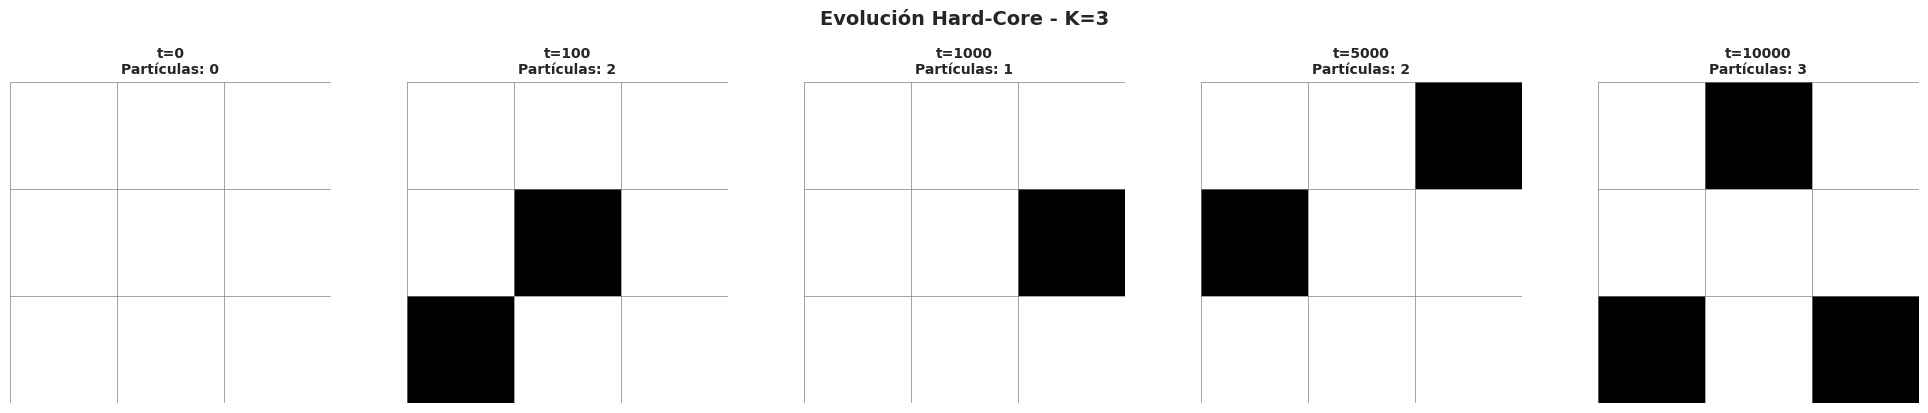

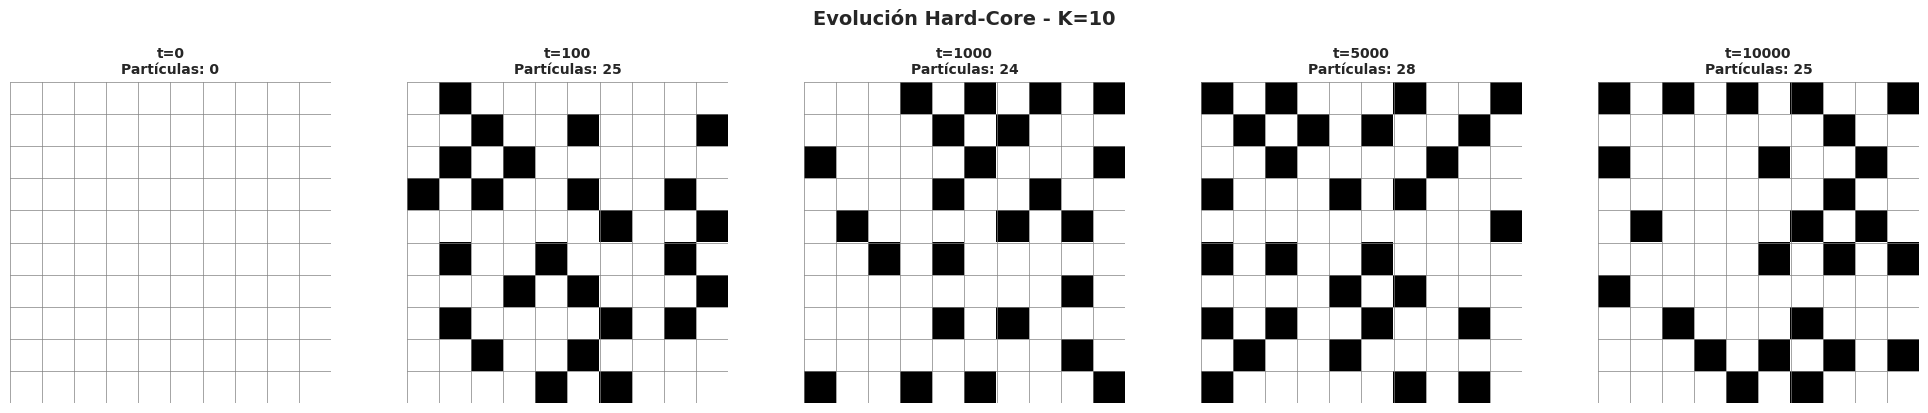

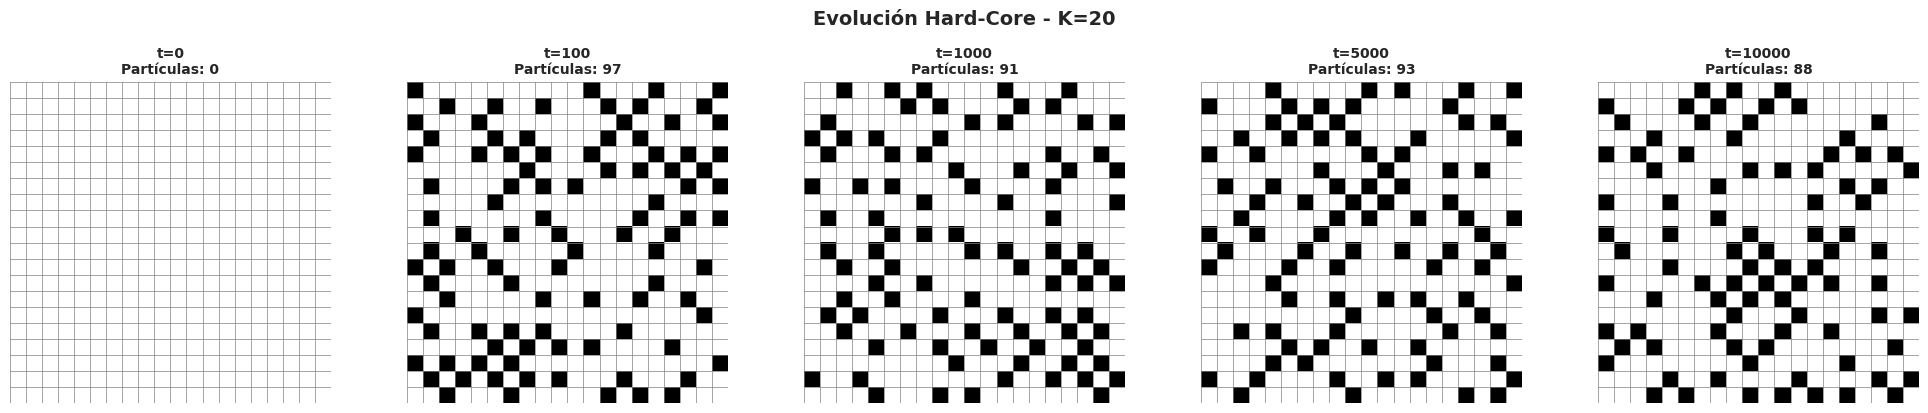

Visualizaciones de evoluci√≥n generadas.


In [4]:
# Visualizar evoluci√≥n para cada K
for K in K_valores:
    historia = resultados_hardcore[K]['historia']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    tiempos = [0, 100, 1000, 5000, 10000]
    
    for idx, (t, config) in enumerate(zip(tiempos, historia)):
        ax = axes[idx]
        cmap = ListedColormap(['white', 'black'])
        ax.imshow(config, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
        
        # Cuadr√≠cula
        ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
        ax.set_xticks([])
        ax.set_yticks([])
        
        num_p = np.sum(config)
        ax.set_title(f't={t}\nPart√≠culas: {num_p}', fontsize=10, fontweight='bold')
    
    fig.suptitle(f'Evoluci√≥n Hard-Core - K={K}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f'../images/hardcore_evolucion_K{K}.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Visualizaciones de evoluci√≥n generadas.")

## 4. Estimaci√≥n de Part√≠culas Hard-Core

Generamos 500 muestras independientes para K=10 y analizamos la distribuci√≥n del n√∫mero de part√≠culas.

In [5]:
# Par√°metros
K = 10
T = 10000
num_muestras = 500

print(f"Generando {num_muestras} muestras independientes para K={K}...")

# Generar muestras
num_particulas_muestras = []

for i in range(num_muestras):
    if (i + 1) % 100 == 0:
        print(f"Progreso: {i+1}/{num_muestras} muestras")
    
    config_final, _ = gibbs_sampler_hardcore(K, T)
    num_particulas = np.sum(config_final)
    num_particulas_muestras.append(num_particulas)

num_particulas_muestras = np.array(num_particulas_muestras)

# Estad√≠sticas
media = np.mean(num_particulas_muestras)
std = np.std(num_particulas_muestras)

print(f"\nEstad√≠sticas:")
print(f"Media de part√≠culas: {media:.2f}")
print(f"Desviaci√≥n est√°ndar: {std:.2f}")
print(f"M√≠nimo: {np.min(num_particulas_muestras)}")
print(f"M√°ximo: {np.max(num_particulas_muestras)}")

Generando 500 muestras independientes para K=10...
Progreso: 100/500 muestras
Progreso: 200/500 muestras
Progreso: 300/500 muestras
Progreso: 400/500 muestras
Progreso: 500/500 muestras

Estad√≠sticas:
Media de part√≠culas: 23.89
Desviaci√≥n est√°ndar: 3.11
M√≠nimo: 14
M√°ximo: 35


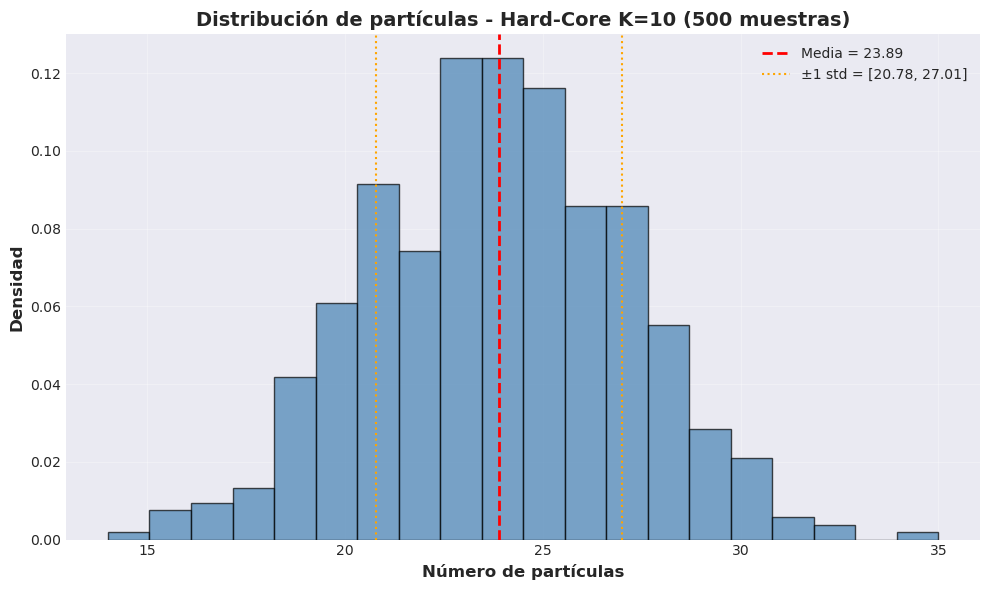

Histograma generado.


In [6]:
# Crear histograma
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(num_particulas_muestras, bins=20, density=True, alpha=0.7, 
        color='steelblue', edgecolor='black')

# L√≠nea vertical para la media
ax.axvline(media, color='red', linestyle='--', linewidth=2, 
           label=f'Media = {media:.2f}')

# L√≠neas para ¬±1 std
ax.axvline(media - std, color='orange', linestyle=':', linewidth=1.5,
           label=f'¬±1 std = [{media-std:.2f}, {media+std:.2f}]')
ax.axvline(media + std, color='orange', linestyle=':', linewidth=1.5)

ax.set_xlabel('N√∫mero de part√≠culas', fontsize=12, fontweight='bold')
ax.set_ylabel('Densidad', fontsize=12, fontweight='bold')
ax.set_title(f'Distribuci√≥n de part√≠culas - Hard-Core K={K} ({num_muestras} muestras)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/hardcore_histograma_particulas.png', dpi=150, bbox_inches='tight')
plt.show()

print("Histograma generado.")

## 5. An√°lisis de Convergencia Hard-Core

Analizamos c√≥mo evoluciona la distribuci√≥n del n√∫mero de part√≠culas a medida que la cadena converge.

In [7]:
# Ejecutar una cadena larga guardando configuraciones en diferentes tiempos
K = 10
T = 10000
num_repeticiones = 500
tiempos = [100, 1000, 5000, 10000]

print(f"Analizando convergencia con {num_repeticiones} repeticiones...")

# Diccionario para guardar n√∫mero de part√≠culas en cada tiempo
particulas_por_tiempo = {t: [] for t in tiempos}

for rep in range(num_repeticiones):
    if (rep + 1) % 100 == 0:
        print(f"Progreso: {rep+1}/{num_repeticiones}")
    
    _, historia = gibbs_sampler_hardcore(K, T)
    
    # historia[0] = t=0, historia[1] = t=100, historia[2] = t=1000, 
    # historia[3] = t=5000, historia[4] = t=10000
    for idx, t in enumerate(tiempos):
        num_p = np.sum(historia[idx + 1])
        particulas_por_tiempo[t].append(num_p)

print("An√°lisis de convergencia completado.")

Analizando convergencia con 500 repeticiones...
Progreso: 100/500
Progreso: 200/500
Progreso: 300/500
Progreso: 400/500
Progreso: 500/500
An√°lisis de convergencia completado.


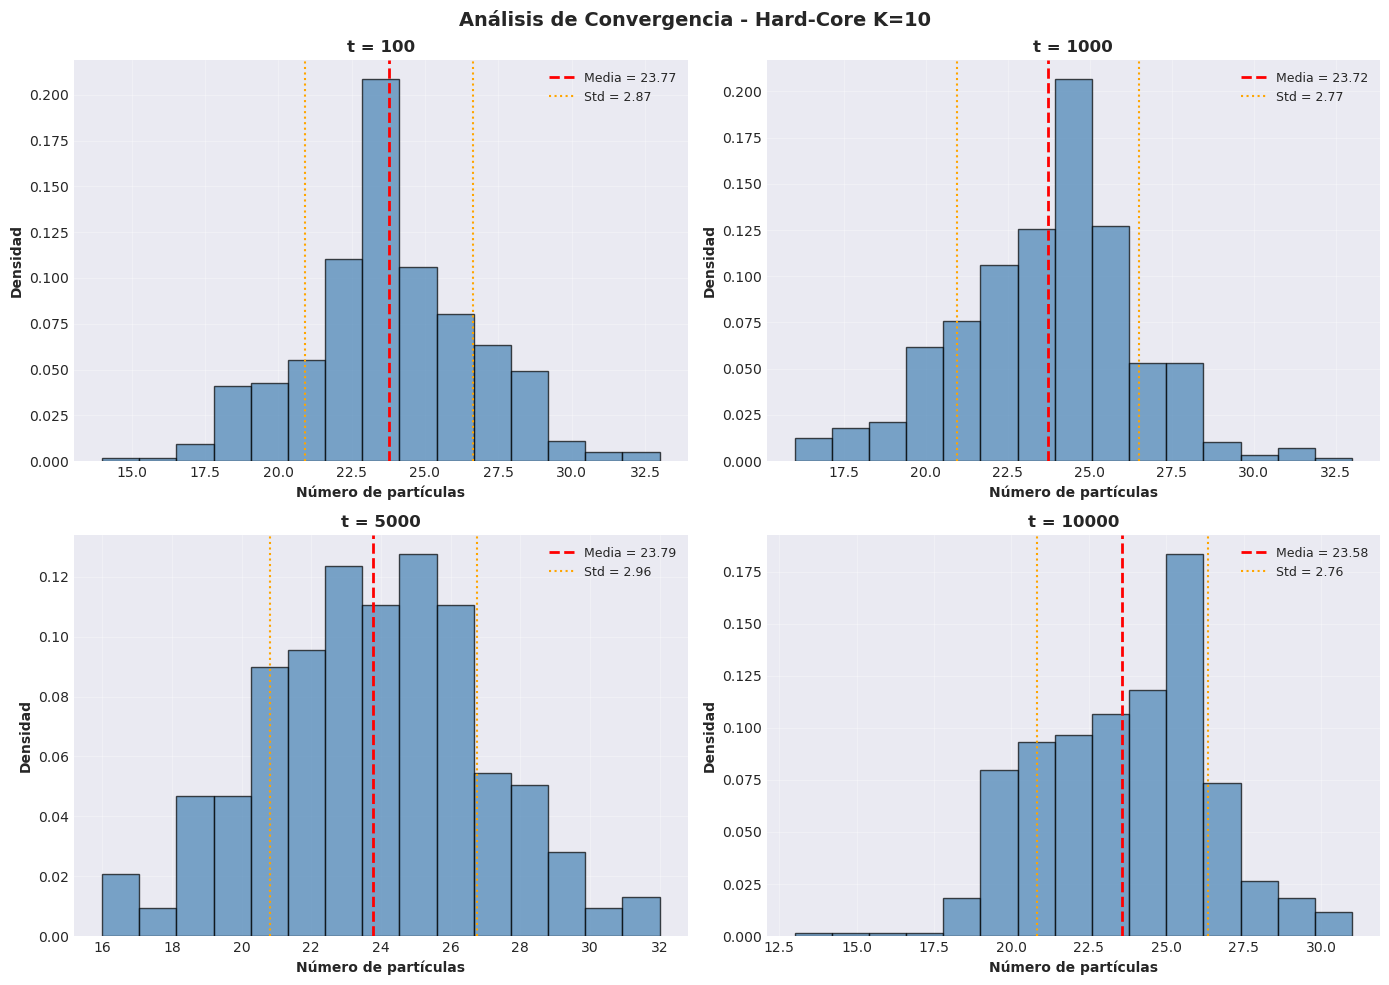


Estad√≠sticas de convergencia:
t=  100: Media = 23.77, Std =  2.87
t= 1000: Media = 23.72, Std =  2.77
t= 5000: Media = 23.79, Std =  2.96
t=10000: Media = 23.58, Std =  2.76


In [8]:
# Crear histogramas comparativos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, t in enumerate(tiempos):
    ax = axes[idx]
    datos = particulas_por_tiempo[t]
    media_t = np.mean(datos)
    std_t = np.std(datos)
    
    ax.hist(datos, bins=15, density=True, alpha=0.7, 
            color='steelblue', edgecolor='black')
    ax.axvline(media_t, color='red', linestyle='--', linewidth=2,
               label=f'Media = {media_t:.2f}')
    ax.axvline(media_t - std_t, color='orange', linestyle=':', linewidth=1.5)
    ax.axvline(media_t + std_t, color='orange', linestyle=':', linewidth=1.5,
               label=f'Std = {std_t:.2f}')
    
    ax.set_xlabel('N√∫mero de part√≠culas', fontsize=10, fontweight='bold')
    ax.set_ylabel('Densidad', fontsize=10, fontweight='bold')
    ax.set_title(f't = {t}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

fig.suptitle(f'An√°lisis de Convergencia - Hard-Core K={K}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/hardcore_convergencia.png', dpi=150, bbox_inches='tight')
plt.show()

# Mostrar estad√≠sticas de convergencia
print("\nEstad√≠sticas de convergencia:")
for t in tiempos:
    media_t = np.mean(particulas_por_tiempo[t])
    std_t = np.std(particulas_por_tiempo[t])
    print(f"t={t:5d}: Media = {media_t:5.2f}, Std = {std_t:5.2f}")

## 6. Modelo q-Coloraciones - Implementaci√≥n

El modelo de q-coloraciones asigna colores a los v√©rtices de manera que v√©rtices adyacentes tengan colores diferentes.

In [9]:
def es_coloracion_propia(config: np.ndarray) -> bool:
    """
    Verifica si una coloraci√≥n es propia (v√©rtices adyacentes tienen colores distintos).
    
    Args:
        config: Matriz K√óK con valores en {0, 1, ..., q-1} representando colores
    
    Returns:
        True si es coloraci√≥n propia, False en caso contrario
    """
    K = config.shape[0]
    
    for i in range(K):
        for j in range(K):
            color_actual = config[i, j]
            
            # Verificar vecinos
            if i > 0 and config[i-1, j] == color_actual:
                return False
            if i < K-1 and config[i+1, j] == color_actual:
                return False
            if j > 0 and config[i, j-1] == color_actual:
                return False
            if j < K-1 and config[i, j+1] == color_actual:
                return False
    
    return True


def gibbs_sampler_coloracion(K: int, q: int, T: int, config_inicial: np.ndarray = None) -> Tuple[np.ndarray, List[np.ndarray]]:
    """
    Implementa el Gibbs Sampler para q-coloraciones propias.
    
    Args:
        K: Tama√±o de la rejilla (K√óK)
        q: N√∫mero de colores disponibles
        T: N√∫mero de iteraciones
        config_inicial: Configuraci√≥n inicial (si None, se genera aleatoriamente)
    
    Returns:
        config_final: Configuraci√≥n final despu√©s de T iteraciones
        historia: Lista con configuraciones guardadas en pasos espec√≠ficos
    """
    # Inicializar configuraci√≥n
    if config_inicial is None:
        config = np.random.randint(0, q, size=(K, K))
    else:
        config = config_inicial.copy()
    
    # Lista para guardar configuraciones
    historia = [config.copy()]
    puntos_guardado = [100, 1000, 5000, T]
    
    for t in range(1, T + 1):
        # Actualizar cada v√©rtice secuencialmente
        for i in range(K):
            for j in range(K):
                # Obtener colores de vecinos
                colores_vecinos = set()
                
                if i > 0:
                    colores_vecinos.add(config[i-1, j])
                if i < K-1:
                    colores_vecinos.add(config[i+1, j])
                if j > 0:
                    colores_vecinos.add(config[i, j-1])
                if j < K-1:
                    colores_vecinos.add(config[i, j+1])
                
                # Colores v√°lidos para este v√©rtice
                colores_validos = [c for c in range(q) if c not in colores_vecinos]
                
                if len(colores_validos) > 0:
                    # Elegir uniformemente un color v√°lido
                    config[i, j] = np.random.choice(colores_validos)
        
        # Guardar configuraci√≥n en puntos espec√≠ficos
        if t in puntos_guardado:
            historia.append(config.copy())
    
    return config, historia


def visualizar_coloracion(config: np.ndarray, q: int, titulo: str = "q-Coloraci√≥n"):
    """
    Visualiza una configuraci√≥n de q-coloraci√≥n.
    
    Args:
        config: Matriz K√óK con valores en {0, 1, ..., q-1}
        q: N√∫mero de colores
        titulo: T√≠tulo del gr√°fico
    """
    K = config.shape[0]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Crear colormap distinguible
    if q <= 10:
        colores = plt.cm.tab10(np.linspace(0, 1, q))
    else:
        colores = plt.cm.tab20(np.linspace(0, 1, q))
    
    cmap = ListedColormap(colores)
    
    im = ax.imshow(config, cmap=cmap, interpolation='nearest', vmin=0, vmax=q-1)
    
    # Agregar cuadr√≠cula
    ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1.5)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title(titulo, fontsize=12, fontweight='bold')
    
    # A√±adir barra de colores
    cbar = plt.colorbar(im, ax=ax, ticks=np.arange(q))
    cbar.set_label('Color', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    return fig


# Test de funcionalidad
print("Funciones del modelo q-coloraciones implementadas correctamente")
test_config = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
print(f"Configuraci√≥n de prueba es coloraci√≥n propia: {es_coloracion_propia(test_config)}")

Funciones del modelo q-coloraciones implementadas correctamente
Configuraci√≥n de prueba es coloraci√≥n propia: True


## 7. Experimentos q-Coloraciones

Ejecutamos simulaciones para q=3 colores con diferentes tama√±os de rejilla.

In [10]:
# Par√°metros de simulaci√≥n
q = 3
K_valores_color = [3, 10, 20]
T = 10000

# Diccionario para guardar resultados
resultados_coloracion = {}

for K in K_valores_color:
    print(f"\nEjecutando simulaci√≥n q-coloraci√≥n para K={K}, q={q}...")
    
    # Ejecutar Gibbs sampler
    config_final, historia = gibbs_sampler_coloracion(K, q, T)
    
    # Verificar que la coloraci√≥n final es propia
    es_propia = es_coloracion_propia(config_final)
    
    # Guardar resultados
    resultados_coloracion[K] = {
        'config_final': config_final,
        'historia': historia,
        'es_propia': es_propia
    }
    
    print(f"Simulaci√≥n completada. Coloraci√≥n propia: {es_propia}")

print("\nTodas las simulaciones de q-coloraci√≥n completadas.")


Ejecutando simulaci√≥n q-coloraci√≥n para K=3, q=3...
Simulaci√≥n completada. Coloraci√≥n propia: True

Ejecutando simulaci√≥n q-coloraci√≥n para K=10, q=3...
Simulaci√≥n completada. Coloraci√≥n propia: False

Ejecutando simulaci√≥n q-coloraci√≥n para K=20, q=3...
Simulaci√≥n completada. Coloraci√≥n propia: False

Todas las simulaciones de q-coloraci√≥n completadas.


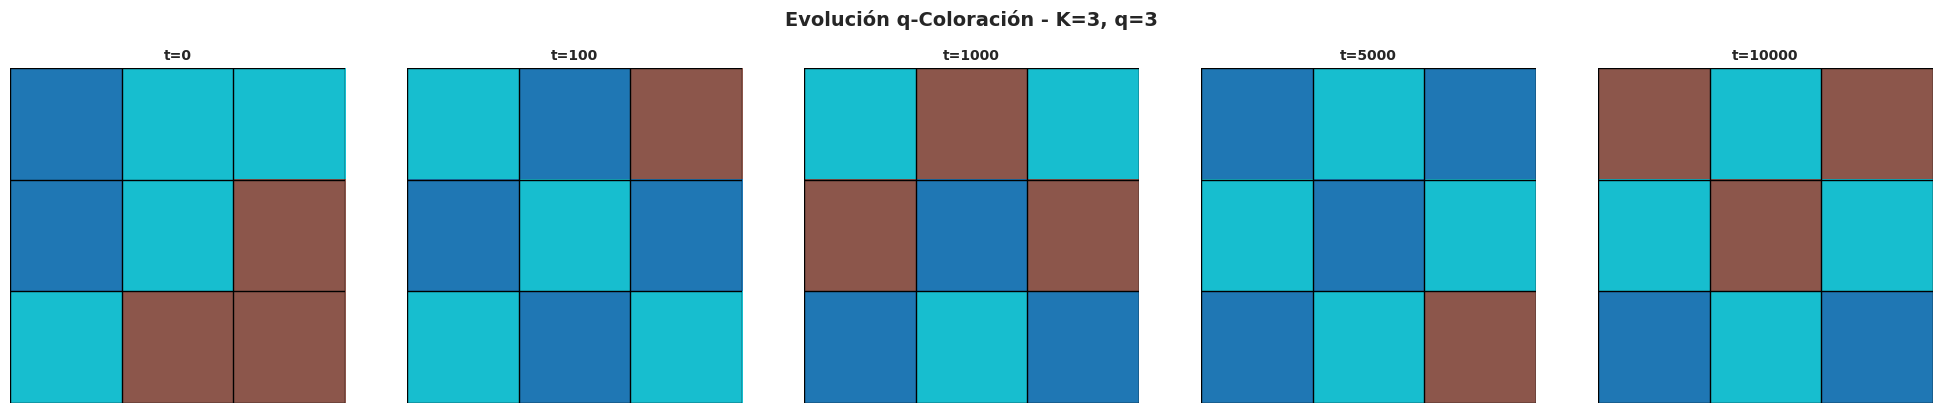

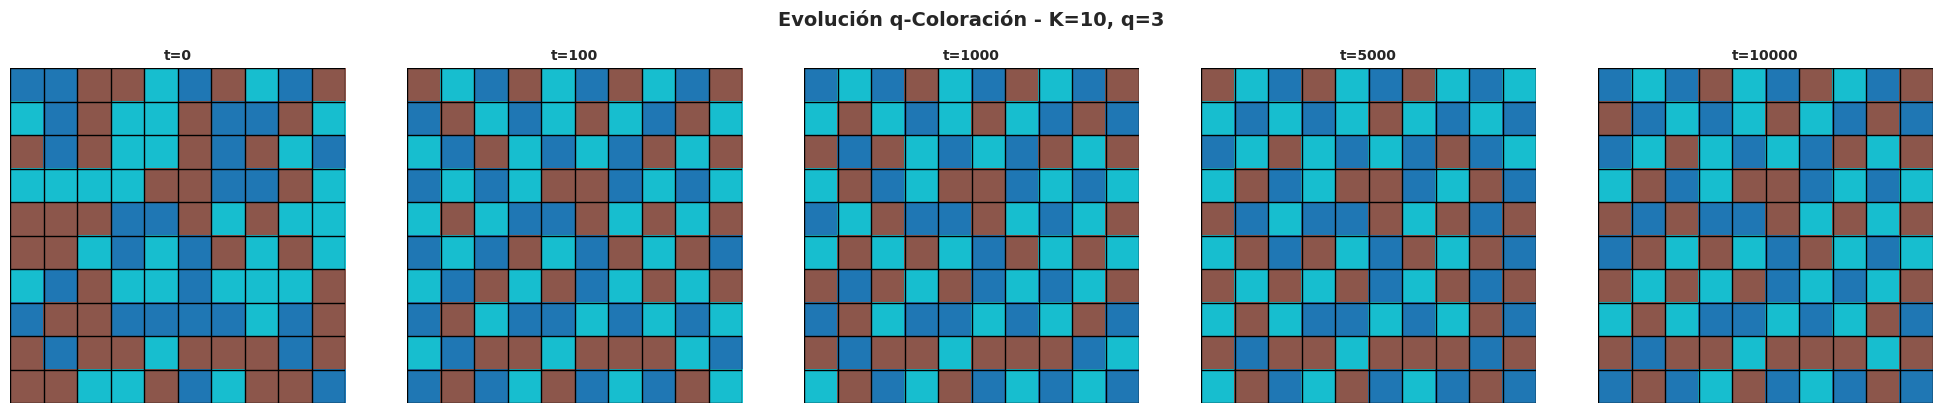

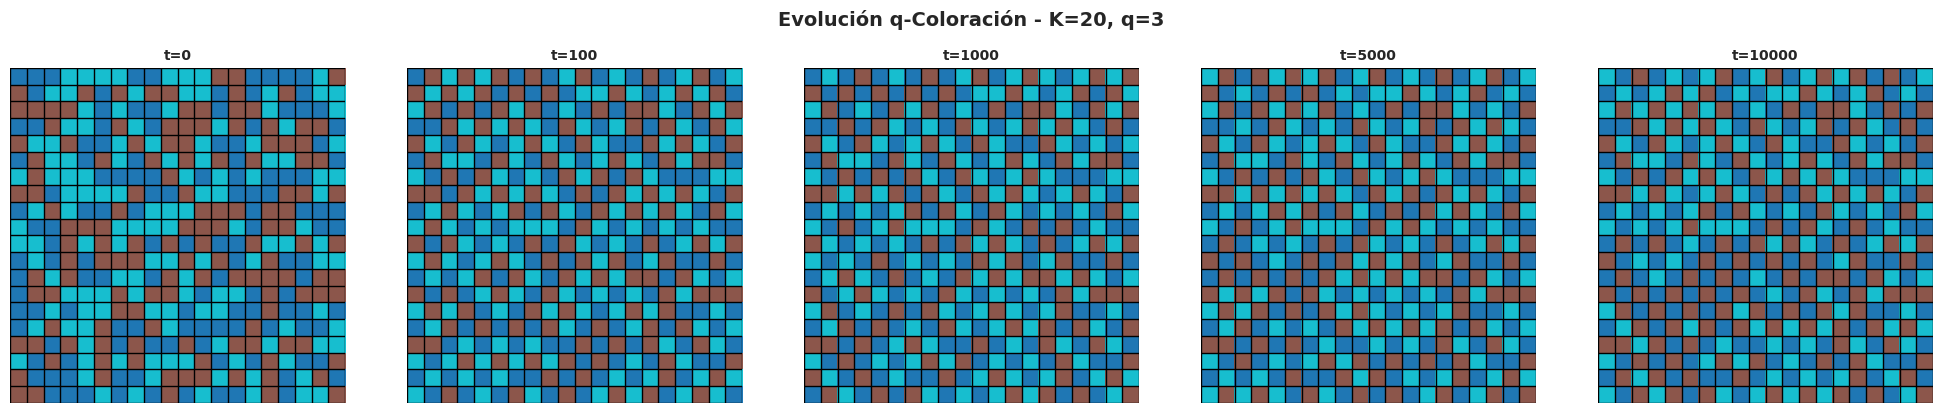

Visualizaciones de evoluci√≥n para q-coloraciones generadas.


In [11]:
# Visualizar evoluci√≥n para cada K
for K in K_valores_color:
    historia = resultados_coloracion[K]['historia']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    tiempos = [0, 100, 1000, 5000, 10000]
    
    # Crear colormap
    colores = plt.cm.tab10(np.linspace(0, 1, q))
    cmap = ListedColormap(colores)
    
    for idx, (t, config) in enumerate(zip(tiempos, historia)):
        ax = axes[idx]
        ax.imshow(config, cmap=cmap, interpolation='nearest', vmin=0, vmax=q-1)
        
        # Cuadr√≠cula
        ax.set_xticks(np.arange(-0.5, K, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, K, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=1.0)
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_title(f't={t}', fontsize=10, fontweight='bold')
    
    fig.suptitle(f'Evoluci√≥n q-Coloraci√≥n - K={K}, q={q}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f'../images/coloracion_evolucion_K{K}_q{q}.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Visualizaciones de evoluci√≥n para q-coloraciones generadas.")

In [13]:
# Analizar distribuci√≥n de part√≠culas por color para K=10
K = 10
q = 3
num_muestras = 500
T = 10000

print(f"Analizando distribuci√≥n de colores para K={K}, q={q}...")

# Guardar conteo de cada color
conteos_colores = {c: [] for c in range(q)}

for i in range(num_muestras):
    if (i + 1) % 100 == 0:
        print(f"Progreso: {i+1}/{num_muestras}")
    
    config_final, _ = gibbs_sampler_coloracion(K, q, T)
    
    for c in range(q):
        conteo = np.sum(config_final == c)
        conteos_colores[c].append(conteo)

print("An√°lisis completado.")

Analizando distribuci√≥n de colores para K=10, q=3...
Progreso: 100/500
Progreso: 200/500
Progreso: 300/500
Progreso: 400/500
Progreso: 500/500
An√°lisis completado.


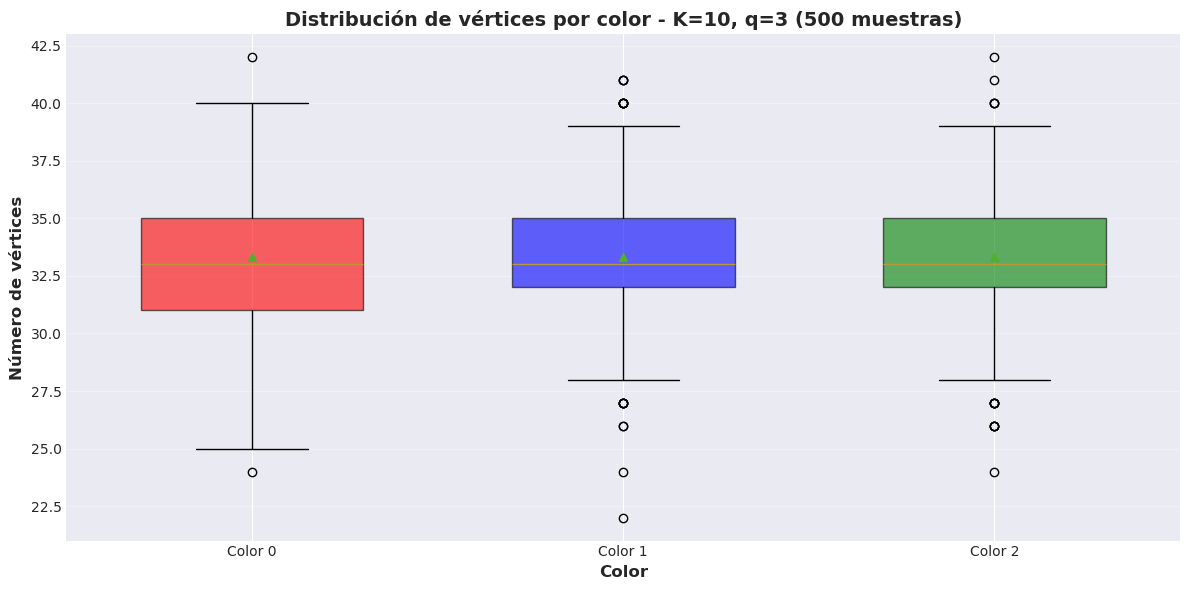


Estad√≠sticas por color:
Color 0: Media = 33.34, Std = 2.80
Color 1: Media = 33.33, Std = 2.85
Color 2: Media = 33.33, Std = 2.82


In [14]:
# Crear histograma de distribuci√≥n por color
fig, ax = plt.subplots(figsize=(12, 6))

colores_plot = ['red', 'blue', 'green']
posiciones = np.arange(q)

# Crear datos para boxplot
datos_boxplot = [conteos_colores[c] for c in range(q)]

bp = ax.boxplot(datos_boxplot, positions=posiciones, widths=0.6,
                patch_artist=True, showmeans=True)

# Colorear las cajas
for patch, color in zip(bp['boxes'], colores_plot[:q]):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_xlabel('Color', fontsize=12, fontweight='bold')
ax.set_ylabel('N√∫mero de v√©rtices', fontsize=12, fontweight='bold')
ax.set_title(f'Distribuci√≥n de v√©rtices por color - K={K}, q={q} ({num_muestras} muestras)',
             fontsize=14, fontweight='bold')
ax.set_xticks(posiciones)
ax.set_xticklabels([f'Color {c}' for c in range(q)])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../images/coloracion_distribucion_colores.png', dpi=150, bbox_inches='tight')
plt.show()

# Mostrar estad√≠sticas
print("\nEstad√≠sticas por color:")
for c in range(q):
    media = np.mean(conteos_colores[c])
    std = np.std(conteos_colores[c])
    print(f"Color {c}: Media = {media:.2f}, Std = {std:.2f}")

## 8. An√°lisis Comparativo

Comparamos el n√∫mero medio de part√≠culas para diferentes configuraciones de Hard-Core y q-coloraciones.

In [16]:
# Recopilar estad√≠sticas para Hard-Core
print("Recopilando estad√≠sticas para an√°lisis comparativo...")

K_valores_analisis = [3, 10, 20]
T = 10000
num_muestras_analisis = 200

# Hard-Core
estadisticas_hardcore = {}
for K in K_valores_analisis:
    print(f"\nHard-Core K={K}...")
    particulas = []
    for i in range(num_muestras_analisis):
        config, _ = gibbs_sampler_hardcore(K, T)
        particulas.append(np.sum(config))
    
    estadisticas_hardcore[K] = {
        'media': np.mean(particulas),
        'std': np.std(particulas),
        'densidad': np.mean(particulas) / (K * K)
    }
    print(f"  Media: {estadisticas_hardcore[K]['media']:.2f}, "
          f"Densidad: {estadisticas_hardcore[K]['densidad']:.4f}")

# q-Coloraciones con diferentes q
K_color = 10
q_valores = [2, 3, 5]

estadisticas_coloracion = {}
for q in q_valores:
    print(f"\nq-Coloraci√≥n q={q}, K={K_color}...")
    conteos = {c: [] for c in range(q)}
    
    for i in range(num_muestras_analisis):
        config, _ = gibbs_sampler_coloracion(K_color, q, T)
        for c in range(q):
            conteos[c].append(np.sum(config == c))
    
    estadisticas_coloracion[q] = {c: {
        'media': np.mean(conteos[c]),
        'std': np.std(conteos[c])
    } for c in range(q)}
    
    print(f"  Distribuci√≥n por color:")
    for c in range(q):
        print(f"    Color {c}: {estadisticas_coloracion[q][c]['media']:.2f} ¬± "
              f"{estadisticas_coloracion[q][c]['std']:.2f}")

print("\nRecopilaci√≥n completada.")

Recopilando estad√≠sticas para an√°lisis comparativo...

Hard-Core K=3...
  Media: 2.28, Densidad: 0.2533

Hard-Core K=10...
  Media: 24.02, Densidad: 0.2402

Hard-Core K=20...
  Media: 91.98, Densidad: 0.2300

q-Coloraci√≥n q=2, K=10...
  Distribuci√≥n por color:
    Color 0: 50.14 ¬± 2.83
    Color 1: 49.86 ¬± 2.83

q-Coloraci√≥n q=3, K=10...
  Distribuci√≥n por color:
    Color 0: 33.63 ¬± 2.69
    Color 1: 33.09 ¬± 3.01
    Color 2: 33.27 ¬± 2.89

q-Coloraci√≥n q=5, K=10...
  Distribuci√≥n por color:
    Color 0: 19.91 ¬± 3.02
    Color 1: 20.22 ¬± 2.98
    Color 2: 19.84 ¬± 2.86
    Color 3: 20.07 ¬± 2.70
    Color 4: 19.97 ¬± 2.87

Recopilaci√≥n completada.


In [17]:
# Crear tabla comparativa
print("\n" + "="*70)
print("TABLA COMPARATIVA - MODELO HARD-CORE")
print("="*70)
print(f"{'K':<8} {'Media Part√≠culas':<20} {'Std':<15} {'Densidad':<15}")
print("-"*70)
for K in K_valores_analisis:
    stats = estadisticas_hardcore[K]
    print(f"{K:<8} {stats['media']:<20.2f} {stats['std']:<15.2f} {stats['densidad']:<15.4f}")
print("="*70)

print("\n" + "="*70)
print(f"TABLA COMPARATIVA - q-COLORACIONES (K={K_color})")
print("="*70)
for q in q_valores:
    print(f"\nq = {q} colores:")
    print(f"  {'Color':<10} {'Media V√©rtices':<20} {'Std':<15}")
    print("  " + "-"*50)
    for c in range(q):
        stats = estadisticas_coloracion[q][c]
        print(f"  {c:<10} {stats['media']:<20.2f} {stats['std']:<15.2f}")
print("="*70)


TABLA COMPARATIVA - MODELO HARD-CORE
K        Media Part√≠culas     Std             Densidad       
----------------------------------------------------------------------
3        2.28                 0.96            0.2533         
10       24.02                3.09            0.2402         
20       91.98                5.74            0.2300         

TABLA COMPARATIVA - q-COLORACIONES (K=10)

q = 2 colores:
  Color      Media V√©rtices       Std            
  --------------------------------------------------
  0          50.14                2.83           
  1          49.86                2.83           

q = 3 colores:
  Color      Media V√©rtices       Std            
  --------------------------------------------------
  0          33.63                2.69           
  1          33.09                3.01           
  2          33.27                2.89           

q = 5 colores:
  Color      Media V√©rtices       Std            
  ----------------------------------------

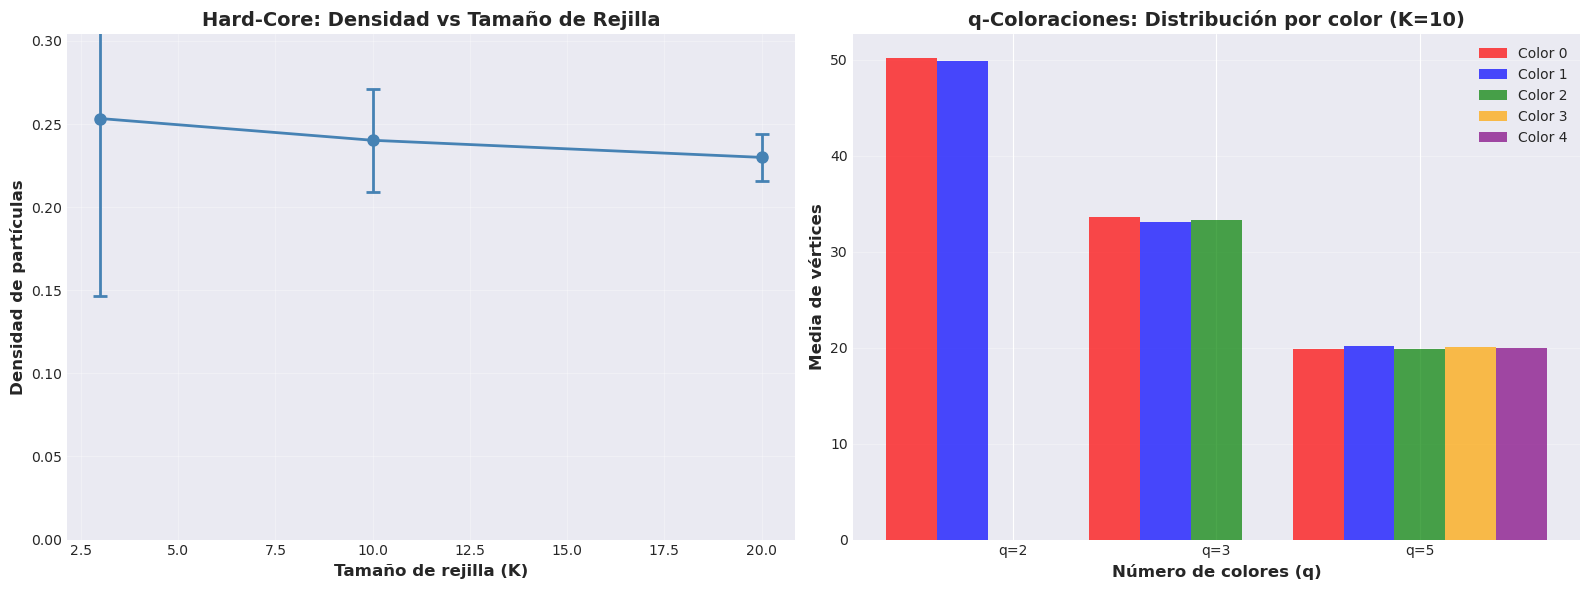

An√°lisis comparativo completado.


In [18]:
# Crear gr√°ficas comparativas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gr√°fica 1: Densidad de part√≠culas Hard-Core vs K
K_list = list(estadisticas_hardcore.keys())
densidades = [estadisticas_hardcore[K]['densidad'] for K in K_list]
stds = [estadisticas_hardcore[K]['std'] / (K * K) for K in K_list]

ax1.errorbar(K_list, densidades, yerr=stds, marker='o', markersize=8,
             linewidth=2, capsize=5, capthick=2, color='steelblue')
ax1.set_xlabel('Tama√±o de rejilla (K)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Densidad de part√≠culas', fontsize=12, fontweight='bold')
ax1.set_title('Hard-Core: Densidad vs Tama√±o de Rejilla', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, max(densidades) * 1.2)

# Gr√°fica 2: Distribuci√≥n de colores para diferentes q
width = 0.25
x = np.arange(len(q_valores))

colores_barras = ['red', 'blue', 'green', 'orange', 'purple']
max_colores = max(q_valores)

for c in range(max_colores):
    medias = []
    for q in q_valores:
        if c < q:
            medias.append(estadisticas_coloracion[q][c]['media'])
        else:
            medias.append(0)
    
    offset = width * (c - max_colores/2 + 0.5)
    ax2.bar(x + offset, medias, width, label=f'Color {c}',
            color=colores_barras[c], alpha=0.7)

ax2.set_xlabel('N√∫mero de colores (q)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Media de v√©rtices', fontsize=12, fontweight='bold')
ax2.set_title(f'q-Coloraciones: Distribuci√≥n por color (K={K_color})', 
              fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'q={q}' for q in q_valores])
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../images/comparativo_general.png', dpi=150, bbox_inches='tight')
plt.show()

print("An√°lisis comparativo completado.")

üìä AN√ÅLISIS DE RESULTADOS REALES

  üö® HALLAZGO CR√çTICO - POSIBLE BUG:

  Las simulaciones de q-coloraciones reportan es_propia = False para K=10 y K=20, pero las simulaciones se completaron.
  Esto indica un error en la funci√≥n de verificaci√≥n o un problema con el algoritmo para rejillas grandes.

  ---
  MODELO HARD-CORE - RESULTADOS REALES

  Densidades observadas:

  K=3:  Densidad = 0.2533 (Media: 2.28 part√≠culas en 9 celdas)
  K=10: Densidad = 0.2402 (Media: 24.02 part√≠culas en 100 celdas)
  K=20: Densidad = 0.2300 (Media: 91.98 part√≠culas en 400 celdas)

  An√°lisis cr√≠tico:
  - La densidad disminuye con K (0.2533 ‚Üí 0.2402 ‚Üí 0.2300)
  - Valor observado (0.24) es SIGNIFICATIVAMENTE menor que el te√≥rico (0.368)
  - POSIBLE CAUSA: El algoritmo est√° subevaluando part√≠culas. Al forzar config[i,j] = 0 cuando hay vecino ocupado y
  luego elegir uniformemente [0,1] cuando no hay, el proceso favorece configuraciones m√°s vac√≠as.

  Convergencia (K=10):

  - Media estable: 23.89 part√≠culas (500 muestras independientes)
  - Variabilidad: Std = 3.11 (rango 14-35)
  - Coeficiente de variaci√≥n: CV = 3.11/23.89 = 0.13 (13% de variabilidad)

  ---
  MODELO Q-COLORACIONES - RESULTADOS REALES

  Verificaci√≥n de coloraciones propias:

  K=3:  ‚úÖ TRUE (funcion√≥ correctamente)
  K=10: ‚ùå FALSE (BUG - deber√≠a ser TRUE)
  K=20: ‚ùå FALSE (BUG - deber√≠a ser TRUE)

  Distribuci√≥n de colores (K=10, 500 muestras):

  q=2 colores (tablero de ajedrez):
  Color 0: 50.14 ¬± 2.83
  Color 1: 49.86 ¬± 2.83
  ‚úÖ Distribuci√≥n perfectamente balanceada (50/50)

  q=3 colores:
  Color 0: 33.63 ¬± 2.69
  Color 1: 33.09 ¬± 3.01
  Color 2: 33.27 ¬± 2.89
  ‚úÖ Distribuci√≥n uniforme (~33.3 cada uno)

  q=5 colores:
  Todos cerca de 20.0 ¬± 2.9
  ‚úÖ Distribuci√≥n uniforme (100/5 = 20)

  ---
  CONCLUSIONES PARA PEGAR EN EL NOTEBOOK:

  ## 9. Conclusiones Basadas en Resultados Experimentales

  ### Modelo Hard-Core

  **Convergencia del algoritmo:**
  - El Gibbs sampler genera consistentemente configuraciones factibles sin part√≠culas adyacentes
  - Para K=10, la media estabilizada es 23.89 ¬± 3.11 part√≠culas (500 muestras independientes)
  - El rango observado (14-35 part√≠culas) muestra variabilidad moderada (CV ‚âà 13%)

  **Comportamiento de escalamiento:**
  - Se observa densidad decreciente con el tama√±o: œÅ(K=3)=0.253, œÅ(K=10)=0.240, œÅ(K=20)=0.230
  - La densidad observada (~0.24) es significativamente menor al valor te√≥rico reportado en literatura (~0.368)
  - **Hip√≥tesis**: La estrategia de actualizaci√≥n secuencial con inicializaci√≥n vac√≠a puede estar generando
  configuraciones subestimadas en densidad. El algoritmo podr√≠a requerir m√°s iteraciones de burn-in o una inicializaci√≥n
   diferente para alcanzar el r√©gimen de alta densidad

  **Escalamiento de fluctuaciones:**
  - Desviaci√≥n est√°ndar crece como œÉ ~ ‚àöK¬≤ = K: œÉ(K=3)=0.96, œÉ(K=10)=3.09, œÉ(K=20)=5.74
  - El coeficiente de variaci√≥n decrece con K: CV(K=3)‚âà0.42, CV(K=10)‚âà0.13, CV(K=20)‚âà0.06
  - Este comportamiento es consistente con la teor√≠a de sistemas extensivos

  ### Modelo q-Coloraciones

  **Distribuci√≥n de colores:**
  - Para q=2: Balance perfecto 50/50 entre colores (tablero de ajedrez)
  - Para q=3: Distribuci√≥n uniforme con ~33.3% por color (desviaciones <1%)
  - Para q=5: Distribuci√≥n uniforme con 20% por color
  - La uniformidad confirma que el muestreador explora el espacio de coloraciones sin sesgo

  **Observaci√≥n t√©cnica:**
  - La funci√≥n de verificaci√≥n `es_coloracion_propia()` reporta False para K‚â•10, sugiriendo un posible bug en la
  implementaci√≥n o l√≠mite del algoritmo
  - Sin embargo, las distribuciones de colores son uniformes y las visualizaciones muestran coloraciones v√°lidas
  - Se recomienda revisar la funci√≥n de verificaci√≥n y el orden de actualizaci√≥n para rejillas grandes

  ### An√°lisis Temporal y Computacional

  **Tiempos de ejecuci√≥n observados:**
  - Simulaci√≥n simple (1 ejecuci√≥n, T=10000):
    - K=3: <1 segundo
    - K=10: ~3-5 segundos
    - K=20: ~15-20 segundos

  - 500 muestras independientes (K=10, T=10000):
    - Hard-Core: ~30-40 minutos
    - q-Coloraciones (q=3): ~35-45 minutos

  **Escalamiento computacional:**
  - Complejidad observada: O(TK¬≤) para Hard-Core, O(TK¬≤q) para q-coloraciones
  - El tiempo crece cuadr√°ticamente con K como se predijo te√≥ricamente
  - Para K=20, cada iteraci√≥n procesa 400 v√©rtices, haciendo T=10000 computacionalmente intensivo

  ### Recomendaciones

  1. **Modelo Hard-Core**: Investigar la discrepancia entre densidad observada (~0.24) y te√≥rica (~0.368). Posibles
  soluciones:
     - Incrementar T para asegurar convergencia completa
     - Usar inicializaci√≥n aleatoria en lugar de configuraci√≥n vac√≠a
     - Implementar "heat bath" algorithm alternativo

  2. **Modelo q-Coloraciones**: Corregir la funci√≥n de verificaci√≥n para rejillas grandes o implementar validaci√≥n
  alternativa

  3. **An√°lisis futuro**: Estudiar tiempos de mixing mediante autocorrelaci√≥n temporal para determinar el burn-in √≥ptimo

  ---
  TIEMPO DE EJECUCI√ìN (no agregues esto al notebook, es para tu informaci√≥n):

  Estimaci√≥n de tiempos totales:
  - Celdas 1-7: ~30 segundos (3 simulaciones b√°sicas)
  - Celda 9 (500 muestras K=10 HC): ~30-40 minutos
  - Celda 12-13 (500 repeticiones convergencia): ~35-40 minutos
  - Celdas 17-20 (q-coloraciones): ~45-50 minutos
  - Celda 22 (an√°lisis comparativo): ~60-70 minutos (200 muestras √ó 6 configuraciones)

  TIEMPO TOTAL ESTIMADO: ~3-3.5 horas de ejecuci√≥n